<a href="https://colab.research.google.com/github/ragaashritha/Project-7/blob/master/Assignment_7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input,concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,ModelCheckpoint

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
train_features.shape
#img_cols
#num_classes

(50000, 32, 32, 3)

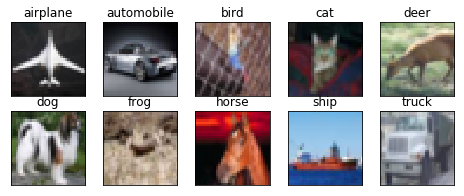

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
import tensorflow as tf
from keras.layers import Lambda

def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

def space_to_depth_x2_output_shape(input_shape):
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])

 


In [9]:
x = Input(shape = (32,32,3))

x1 = SeparableConv2D(16,3,3,border_mode = 'same',activation = 'relu')(x)#depthwise 5x5 - 32
x1 = BatchNormalization()(x1)
#skip connection prep x1
x1_16 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x1) # -16
x1_16 = Convolution2D(16,1,1,activation = 'relu')(x1_16)
x1_8 = Lambda(space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x1_16)
x1_8 = Convolution2D(16,1,1,activation = 'relu')(x1_8)

x2 = Convolution2D(32,5,5,border_mode = 'same',activation = 'relu')(x1)#Convolution - 5x5 - 32
x2 = BatchNormalization()(x2)
#skip connection prep x1
x2_16 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x2) # -16
x2_16 = Convolution2D(16,1,1,activation = 'relu')(x2_16)
x2_8 = Lambda(space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x2_16)
x2_8 = Convolution2D(16,1,1,activation = 'relu')(x2_8)

x3 = Convolution2D(64,5,5,border_mode = 'same',activation = 'relu')(x2)#Convolution - 5x5 - 32
x3 = BatchNormalization()(x3)
x3 = Convolution2D(16,3,3,border_mode = 'same',activation = 'relu')(x3)##skip connection prep -32
x3 = BatchNormalization()(x3)
x3 = add([x3,x1])#skip connection -32
x3 = Dropout((0.25))(x3)
#skip connection prep x1
x3_16 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x3) #-16
x3_16 = Convolution2D(16,1,1,activation = 'relu')(x3_16)
x3_8 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x3_16) #-8
x3_8 = Convolution2D(16,1,1,activation = 'relu')(x3_8)



x4 = SeparableConv2D(32,5,1,border_mode='same',activation = 'relu')(x3)##depthwise 5x5 -32
x4 = BatchNormalization()(x4)
x4 = Convolution2D(16,3,3,border_mode = 'same',activation = 'relu')(x4)##skip connection prep -32
x4 = BatchNormalization()(x4)
x4 = Dropout((0.25))(x4)
#skip connection prep x1
x4_16 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x4) #-16
x4_16 = Convolution2D(16,1,1,activation = 'relu')(x4_16)
x4_8 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x4_16) #-8
x4_8 = Convolution2D(16,1,1,activation = 'relu')(x4_8)


x5 = add([x4,x1]) #skip connection -32
x5 = MaxPooling2D((2,2))(x5)#Maxpooling -16
x5 = Dropout((0.25))(x5)

x6 = SeparableConv2D(32,3,1,border_mode='same',activation = 'relu')(x5)##depthwise 3x3 -16
x6 = BatchNormalization()(x6)
x6 = Convolution2D(16,3,3,border_mode = 'same',activation = 'relu')(x6)##skip connection prep -16
x6 = BatchNormalization()(x6)
x6_8 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x6) #-16
x6_8 = Convolution2D(16,1,1,activation = 'relu')(x6_8)


x7 = add([x6,x1_16]) #skip connection -16
x7 = Convolution2D(64,5,5,border_mode='same',activation = 'relu')(x7) #-16
x7 = BatchNormalization()(x7)
x7 = Convolution2D(16,3,3,border_mode = 'same',activation = 'relu')(x7)##skip connection prep -16
x7 = BatchNormalization()(x7)
x7_8 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x7) #-16
x7_8 = Convolution2D(16,1,1,activation = 'relu')(x7_8)



x8 = add([x3_16,x4_16,x6,x7])#skip connection -16
x8 = SeparableConv2D(128,3,1,border_mode='same',activation = 'relu')(x8)##depthwise 3x3 -16
x8 = BatchNormalization()(x8)
x8 = Convolution2D(16,3,3,border_mode='same',activation = 'relu')(x8)##skip connection prep -16
x8 = BatchNormalization()(x8)
x8_8 = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape)(x8) #-16
x8_8 = Convolution2D(16,1,1,activation = 'relu')(x8_8)


x9 = add([x1_16,x7,x4_16,x6,x8])#skip connection -16
x9 = SeparableConv2D(128,5,1,border_mode='same',activation = 'relu')(x9)##depthwise 5x5 -16
x9 = BatchNormalization()(x9)
x9 = Convolution2D(16,3,3,border_mode='same',activation = 'relu')(x9)##skip connection prep -16
x9 = BatchNormalization()(x9)

#Maxpooling
x10 = add([x8,x4_16,x6,x1_16,x9])
x10 = MaxPooling2D((2,2))(x10)#Maxpooling -8
x10 = Dropout((0.25))(x10)

#Convolution 5x5
x11 = add([x10,x7_8])
x11 = Convolution2D(128,5,5,border_mode='same',activation='relu')(x10) #-8
x11 = BatchNormalization()(x11)
x11 = Convolution2D(16,3,3,border_mode='same',activation = 'relu')(x11)##skip connection prep -16
x11 = BatchNormalization()(x11)

#Seperable - 1x5,5x1
x12 = add([x2_8,x8_8,x1_8,x11])
x12 = SeparableConv2D(256,5,1,border_mode='same',activation = 'relu')(x12) #-8
x12 = BatchNormalization()(x12)
x12 = Convolution2D(16,3,3,border_mode='same',activation = 'relu')(x12)##skip connection prep -16
x12 = BatchNormalization()(x12)


#Convolution- 3x3
x13 = add([x6_8,x2_8,x3_8,x11,x12])
x13 = Convolution2D(128,3,3,border_mode='same',activation='relu')(x13)
x13 = BatchNormalization()(x13)
x13 = Convolution2D(16,3,3,border_mode='same',activation = 'relu')(x13)##skip connection prep -16
x13 = BatchNormalization()(x13)

#seperable 5x5
x14  = add([x12,x3_8,x8_8,x4_8,x6_8,x1_8,x13])
x14 =  SeparableConv2D(64,5,1,border_mode='same',activation='relu')(x14)
x14 = BatchNormalization()(x14)

#1x1
x15 = Convolution2D(32,1,1,border_mode='same',activation='relu')(x14)
x15 = BatchNormalization()(x15)
#softmax
x16 = Convolution2D(10,8,8)(x15)
x17 = Flatten()(x16)
output = Dense(10,activation='softmax')(x17)

model = Model(inputs= x,outputs = output)
model.summary()




W0618 15:47:02.447486 140511909455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 15:47:02.484896 140511909455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(16, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0618 15:47:02.495985 140511909455744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 16)   91          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   12832       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8))`


In [0]:
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
callbacks = [LearningRateScheduler(scheduler, verbose=1)]
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=195, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 28s 143ms/step - loss: 1.3336 - acc: 0.5186 - val_loss: 1.3215 - val_acc: 0.5279
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 27s 139ms/step - loss: 1.1250 - acc: 0.5978 - val_loss: 1.3023 - val_acc: 0.5450
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 27s 140ms/step - loss: 0.9584 - acc: 0.6595 - val_loss: 1.0110 - val_acc: 0.6457
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [==============================] - 28s 143ms/step - loss: 0.8463 - acc: 0.7006 - val_loss: 1.0210 - val_acc: 0.6458
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
195/195 [==============================] - 28s 142ms/step - loss: 0.7552 - a

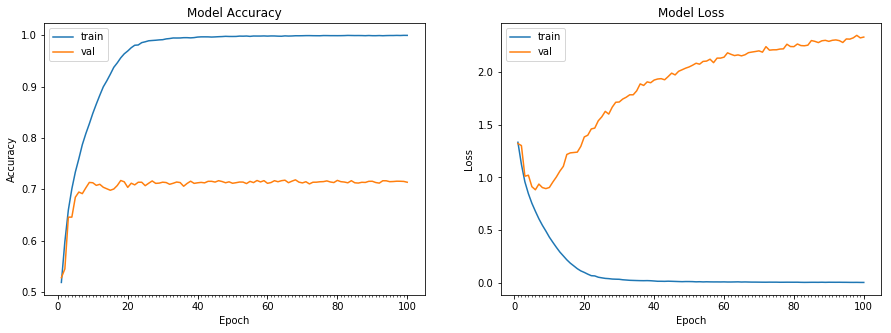

Accuracy on test data is: 71.37


In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels),  callbacks=callbacks,verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))